### Import Dataset

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

In [111]:
df1 = pd.read_csv('data/Final_Label_10000.csv')
df1 = df1[df1['Tagger ID'] == 'jy']
print(df1.shape)
df1.head()

df2 = pd.read_csv('data/jincheng3000.csv')
print(df2.shape)

df =pd.concat([df1, df2], ignore_index=True)

df = df.drop(['commit link_x', 'excluded','Commit ID','total_files','deleted_files','check', 'Tagger ID','commit link','testing', 'build'], axis = 1)
df = df[['application', 'csha', 'commit message', 'maintenance', 'Bug fix', 
        'Documentation', 'Clean up','Source Control', 'Feature Add', 'Merge', 'Refactoring','Token Replace']]
print(df.shape)
df.head()

(2952, 22)
(2952, 22)
(5904, 12)


,application,csha,commit message,maintenance,Bug fix,Documentation,Clean up,Source Control,Feature Add,Merge,Refactoring,Token Replace
0,google-closure-compiler,d84964855e190bf663d38b7fa37f3746deb2b3aa,chang look extend interfac first,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,google-closure-compiler,d1a63725ce21a1c6901ec762dd745ac58b8866b2,support,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,google-closure-compiler,47f75968703051dc09ed001ee84cce81e78835f7,mark,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,google-closure-compiler,ee5c095b4237da991a911fa459514ca942ede7e0,remov thread warn report use think anyon under...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,google-closure-compiler,fc1f4e841b3ef0f6fa4578b673e803c3df733a0d,make class statement call work correct fix,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tags Preprocessing

In [112]:
new_df = df.copy()
def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Source Control'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

Corrective : 627
Adaptive : 742
Perfective : 3338
Implementation : 864
Non_functional : 95
Other : 95


Corrective : 627
Adaptive : 742
Perfective : 3338
Implementation : 864
1    5020
0     613
2     262
3       9
dtype: int64


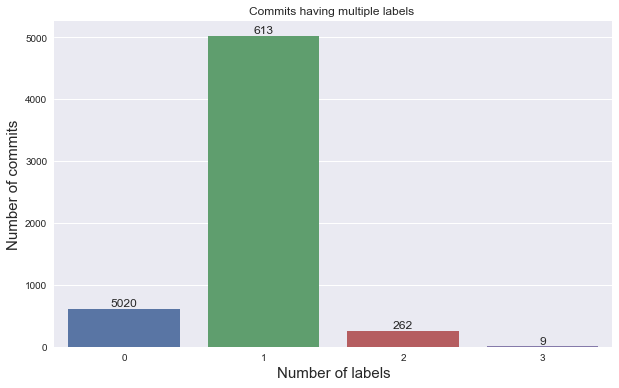

current number of samples: 5904
number of samples after drop:5020


In [113]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
# new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Perfective','Implementation']

# new_df = new_df[new_df['Perfective']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Implementation','Corrective']

# form target cols
new_df['target_class'] = np.argmax(new_df[target_col].values, axis = 1)
new_df = new_df[~new_df['commit message'].isnull()]

### Message Tokenize and Padding

In [114]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

26


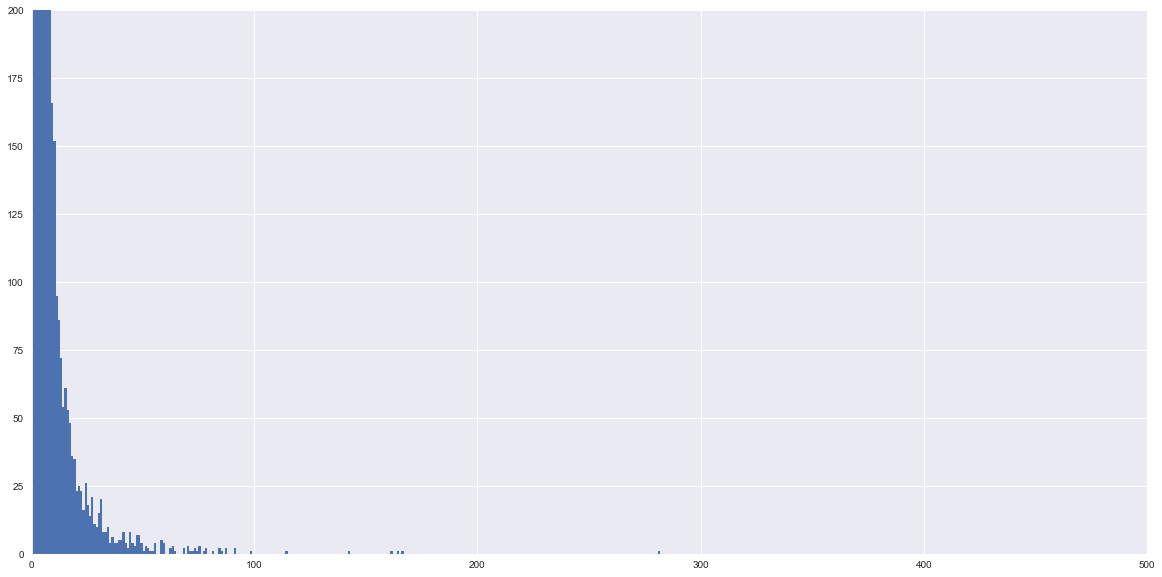

In [115]:
def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 200))

number_of_words = [len(message.split()) for message in new_df['commit message'].values]
plot_hist(number_of_words)

# getting file threshold
threshold = 0.95

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_words, threshold)
print(length_threshold)

In [116]:
# drop too long commits
new_df['len_seq'] = new_df.apply(lambda row: len(row['commit message'].split()), axis = 1)
new_df = new_df[new_df['len_seq'] >= 1].reset_index(drop = True)

In [117]:
#Training 
docs = new_df['commit message'].values
t = Tokenizer(filters = '', lower=False)
t.fit_on_texts(docs)

sequences = t.texts_to_sequences(docs)
print(sequences[0])

#Pad data 
padded_seq = pad_sequences(sequences, maxlen= length_threshold, padding="post", truncating="post")
print(padded_seq[0])
print(padded_seq.shape)

# vocabulary
vocabulary = t.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print('Vocab_size : %d'%len(vocabulary_inv.keys()))

[7, 276, 189, 73, 113]
[  7 276 189  73 113   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
(4900, 26)
Vocab_size : 2553


In [118]:
X = padded_seq
y = new_df[target_col].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# print('X train shape : ', X_train.shape)
# print('X test shape : ', X_test.shape)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
# print('X train shape : ', X_train.shape)
# print('X val shape : ', X_val.shape)

### CNN

In [119]:
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D,GlobalMaxPooling1D, Convolution1D, Embedding, Reshape,Conv2D, MaxPool2D
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.layers.merge import Concatenate
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import set_random_seed
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import warnings
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score, classification_report, confusion_matrix

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
warnings.filterwarnings('ignore')

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))

In [120]:
def CNN_model(sequence_length, vocab_size, 
              embedding_dim = 64, 
              filter_sizes = (5,5,5),  
              num_filters = 128,  
              drop_prob = 0.4, 
              hidden_dims = 128, 
              n_class = 4):
    
    # input
    inputs = Input(shape=(sequence_length, ),  dtype='int32')
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    # Convolutional block
    conv_blocks = []
    for filter_size in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
        conv = Convolution1D(filters=num_filters,
                         kernel_size=filter_size,
                         padding="same",
                         activation="relu",
                         strides=1,
                         use_bias=True)(embedding)
        
        conv = GlobalMaxPooling1D()(conv) # 1-Max pooling

        conv_blocks.append(conv)

    concatenate = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    
    dropout = Dropout(drop_prob)(concatenate)
    
    output_layer = Dense(hidden_dims, activation='relu',
                         kernel_regularizer=regularizers.l2(0.1),bias_regularizer=regularizers.l1(0.1)
                        )(dropout)
    

    output = Dense(n_class, activation="softmax")(output_layer)

    model = Model(inputs, output)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="categorical_crossentropy", optimizer= adam, metrics=["accuracy"])
    
    return model

cnn = CNN_model(100, 500)
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 100, 64)      32000       input_25[0][0]                   
__________________________________________________________________________________________________
conv1d_73 (Conv1D)              (None, 100, 128)     41088       embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_74 (Conv1D)              (None, 100, 128)     41088       embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_75 

In [109]:
cnn_model = CNN_model(X_train.shape[1],
                      len(vocabulary_inv.keys()),
                      embedding_dim = 256, 
                      filter_sizes = (5,5,5),  
                      num_filters = 256,  
                      drop_prob = 0.4, 
                      hidden_dims = 128, n_class = 4)

early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.01, patience = 10, verbose = 0, restore_best_weights = True)
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')

history = cnn_model.fit(X_train, y_train, batch_size=256, epochs=200,
                            validation_data=(X_test, y_test), verbose=1, shuffle = False, callbacks = [early_stop])

y_pred = np.argmax(cnn_model.predict(X_test), axis = 1)
y_test_new = np.argmax(y_test, axis = 1)
print_evaluation_scores(y_test_new, y_pred)

Train on 3931 samples, validate on 437 samples
Epoch 1/200
3931/3931 [==============================] - 23s 6ms/step - loss: 18.2121 - acc: 0.6634 - val_loss: 12.8522 - val_acc: 0.6888
Epoch 2/200
3931/3931 [==============================] - 17s 4ms/step - loss: 9.6955 - acc: 0.7011 - val_loss: 6.6077 - val_acc: 0.6888
Epoch 3/200
3931/3931 [==============================] - 17s 4ms/step - loss: 4.8980 - acc: 0.7049 - val_loss: 3.3358 - val_acc: 0.6819
Epoch 4/200
3931/3931 [==============================] - 17s 4ms/step - loss: 2.4480 - acc: 0.7454 - val_loss: 1.7723 - val_acc: 0.7140
Epoch 5/200
3931/3931 [==============================] - 21s 5ms/step - loss: 1.2769 - acc: 0.7942 - val_loss: 1.1246 - val_acc: 0.7254
Epoch 6/200
3931/3931 [==============================] - 19s 5ms/step - loss: 0.7529 - acc: 0.8367 - val_loss: 0.9447 - val_acc: 0.7300
Epoch 7/200
3931/3931 [==============================] - 19s 5ms/step - loss: 0.5261 - acc: 0.8586 - val_loss: 0.9333 - val_acc: 0.7254

### Cross Validation

In [129]:
from sklearn.model_selection import KFold, StratifiedKFold

def cnn_train(X_train, y_train, X_test, y_test):
    cnn_model = CNN_model(X_train.shape[1],
                          len(vocabulary_inv.keys()),
                          embedding_dim = 128, 
                          filter_sizes = (5,5,5),  
                          num_filters = 256,  
                          drop_prob = 0.4, 
                          hidden_dims = 128, n_class = 4)

    early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.01, patience = 10, verbose = 0, restore_best_weights = True)
    checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')

    history = cnn_model.fit(X_train, y_train, batch_size=256, epochs=20,
                                validation_data=(X_test, y_test), verbose=1, shuffle = False, callbacks = [early_stop])

    y_pred = np.argmax(cnn_model.predict(X_test), axis = 1)
    y_test_new = np.argmax(y_test, axis = 1)
    print_evaluation_scores(y_test_new, y_pred)
    
    accu = accuracy_score(y_test_new, y_pred)
    f1 = f1_score(y_test_new, y_pred, average='macro')
    
    return accu, f1

In [130]:
skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
skf.get_n_splits(X, y)
y_new = np.argmax(y, axis = 1)

eval_result = []
for train_index, test_index in skf.split(X, y_new):
    print('========================================================')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    accu, f1 = cnn_train(X_train, y_train, X_test, y_test)
    
    eval_result.append((accu,f1))

Train on 4407 samples, validate on 493 samples
Epoch 1/20
4407/4407 [==============================] - 14s 3ms/step - loss: 17.8570 - acc: 0.5963 - val_loss: 12.0693 - val_acc: 0.6207
Epoch 2/20
4407/4407 [==============================] - 12s 3ms/step - loss: 8.8841 - acc: 0.6236 - val_loss: 5.8055 - val_acc: 0.6207
Epoch 3/20
4407/4407 [==============================] - 13s 3ms/step - loss: 4.3007 - acc: 0.6149 - val_loss: 2.8682 - val_acc: 0.6207
Epoch 4/20
4407/4407 [==============================] - 11s 3ms/step - loss: 2.2289 - acc: 0.5954 - val_loss: 1.6388 - val_acc: 0.6389
Epoch 5/20
4407/4407 [==============================] - 11s 2ms/step - loss: 1.3639 - acc: 0.6324 - val_loss: 1.1675 - val_acc: 0.6308
Epoch 6/20
4407/4407 [==============================] - 11s 2ms/step - loss: 1.0201 - acc: 0.6415 - val_loss: 1.0287 - val_acc: 0.6491
Epoch 7/20
4407/4407 [==============================] - 11s 2ms/step - loss: 0.8805 - acc: 0.6669 - val_loss: 1.0219 - val_acc: 0.6410
Epoch 

4411/4411 [==============================] - 17s 4ms/step - loss: 17.9445 - acc: 0.5865 - val_loss: 12.1290 - val_acc: 0.6237
Epoch 2/20
4411/4411 [==============================] - 12s 3ms/step - loss: 8.9237 - acc: 0.6228 - val_loss: 5.8549 - val_acc: 0.6237
Epoch 3/20
4411/4411 [==============================] - 11s 2ms/step - loss: 4.3429 - acc: 0.6119 - val_loss: 2.8936 - val_acc: 0.6217
Epoch 4/20
4411/4411 [==============================] - 11s 2ms/step - loss: 2.2733 - acc: 0.5976 - val_loss: 1.6553 - val_acc: 0.6585
Epoch 5/20
4411/4411 [==============================] - 10s 2ms/step - loss: 1.3784 - acc: 0.6300 - val_loss: 1.1854 - val_acc: 0.6339
Epoch 6/20
4411/4411 [==============================] - 11s 2ms/step - loss: 1.0378 - acc: 0.6448 - val_loss: 1.0511 - val_acc: 0.6217
Epoch 7/20
4411/4411 [==============================] - 11s 2ms/step - loss: 0.8937 - acc: 0.6620 - val_loss: 1.0119 - val_acc: 0.6360
Epoch 8/20
4411/4411 [==============================] - 11s 2ms/

4411/4411 [==============================] - 13s 3ms/step - loss: 0.8910 - acc: 0.6776 - val_loss: 1.0762 - val_acc: 0.6115
Epoch 8/20
4411/4411 [==============================] - 13s 3ms/step - loss: 0.8187 - acc: 0.7112 - val_loss: 1.0755 - val_acc: 0.6196
Epoch 9/20
4411/4411 [==============================] - 13s 3ms/step - loss: 0.7457 - acc: 0.7533 - val_loss: 1.0832 - val_acc: 0.6278
Epoch 10/20
4411/4411 [==============================] - 12s 3ms/step - loss: 0.6709 - acc: 0.7989 - val_loss: 1.1378 - val_acc: 0.6115
Epoch 11/20
4411/4411 [==============================] - 13s 3ms/step - loss: 0.6309 - acc: 0.8087 - val_loss: 1.1828 - val_acc: 0.5951
Epoch 12/20
4411/4411 [==============================] - 12s 3ms/step - loss: 0.6053 - acc: 0.8250 - val_loss: 1.1887 - val_acc: 0.6155
Epoch 13/20
4411/4411 [==============================] - 13s 3ms/step - loss: 0.5410 - acc: 0.8572 - val_loss: 1.1827 - val_acc: 0.5992
Epoch 14/20
4411/4411 [==============================] - 12s 3

4411/4411 [==============================] - 13s 3ms/step - loss: 0.5970 - acc: 0.8270 - val_loss: 1.1672 - val_acc: 0.6012
Epoch 13/20
4411/4411 [==============================] - 15s 3ms/step - loss: 0.5413 - acc: 0.8538 - val_loss: 1.2509 - val_acc: 0.5828
Epoch 14/20
4411/4411 [==============================] - 15s 3ms/step - loss: 0.5212 - acc: 0.8549 - val_loss: 1.3599 - val_acc: 0.5542
Accuracy: 0.656441717791411
F1-score macro: 0.34457175717728716
F1-score micro: 0.656441717791411
F1-score weighted: 0.557404336481863


In [131]:
sum_acc = 0
sum_f1 = 0
for item in eval_result:
    sum_acc += item[0]
    sum_f1 += item[1]

print(sum_acc/10)
print(sum_f1/10)

0.6594085441783663
0.4055663476660136
